In [ ]:
%reset -f

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import ee
ee.Authenticate()


Mounted at /content/drive


In [ ]:
import ee

ee.Initialize(project='ee-andrewfullhart')

ic = ee.ImageCollection('NASA/NEX-GDDP')

study_area = ee.FeatureCollection('users/andrewfullhart/SW_Study_Area')

ndays_months = ee.List([31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
order_months = ee.List([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

inFILE = '/content/drive/My Drive/Colab Notebooks/GHCN_Historical_Annual_Mean_MEANP_Trends_Results.csv'

with open(inFILE) as f:
  lines = f.readlines()

points_ft_list = ee.List([])
for line in lines[1:]:
  row = line.strip('\n').split(',')
  lon = float(row[1])
  lat = float(row[2])
  ft = ee.Feature(None, {}).setGeometry(ee.Geometry.Point(lon, lat))
  points_ft_list = points_ft_list.add(ft)

points_fc = ee.FeatureCollection(points_ft_list)

#first_im = ic.first()
#points_fc = first_im.sample(region=study_area, geometries=True)
#points_fc = ee.FeatureCollection(points_fc.toList(10).slice(0, 10))

start_year_global = 2014
end_year_global = 2099
years_list_global = ee.List.sequence(start_year_global, end_year_global)
years_index_global = ee.List.sequence(0, years_list_global.size().subtract(1))

def pointlabel_fn(point):
  point = ee.Feature(point).geometry()
  a_strng = ee.Number(point.coordinates().get(0)).format('%.3f')
  b_strng = ee.String('_')
  c_strng = ee.Number(point.coordinates().get(1)).format('%.3f')
  point_strng = a_strng.cat(b_strng).cat(c_strng)
  point_strng = point_strng.replace('\\.', '_', 'g').slice(1)
  return point_strng

point_labels_global = points_fc.toList(points_fc.size()).map(pointlabel_fn)

def year_fn(year):
  year = ee.Number(year)
  start = ee.Date.fromYMD(ee.Number(year), 1, 1)
  end = ee.Date.fromYMD(ee.Number(year), 12, 31)
  year_ic = ic.filterDate(start, end).select('pr')
  modelfilter = ee.Filter.Or(
                ee.Filter.eq('scenario', 'historical'),
                ee.Filter.eq('scenario', 'rcp45'))
  year_ic = year_ic.filter(modelfilter)
  year_ic = year_ic.filter(ee.Filter.eq('model', 'CCSM4'))

  def point_fn(point):
    point = point.geometry()
    a_strng = ee.Number(point.coordinates().get(0)).format('%.3f')
    b_strng = ee.String('_')
    c_strng = ee.Number(point.coordinates().get(1)).format('%.3f')
    point_strng = a_strng.cat(b_strng).cat(c_strng)
    point_strng = point_strng.replace('\\.', '_', 'g').slice(1)
    data_list = year_ic.getRegion(point, 500).slice(1)

    def feature_fn(l):
      l = ee.List(l)
      date_str = ee.String(ee.String(l.get(0)).split('_').get(-1))
      year = ee.Number(date_str.slice(0, 4))
      month = ee.Number(date_str.slice(4, 6))
      prcp = ee.Number(l.get(4))
      prop_dict = {'year':year, 'month':month, 'precip':prcp}
      point_ft = ee.Feature(None, prop_dict)
      return point_ft

    data_fc = ee.FeatureCollection(data_list.map(feature_fn))
    nonzero_fc = data_fc.filter(ee.Filter.gt('precip', 0))
    number = ee.Number(nonzero_fc.reduceColumns(ee.Reducer.mean(), ['precip']).get('mean')).multiply(86400)
    number_ft = ee.Feature(None, {'point':point_strng,'mean':number})
    return number_ft

  means_fc = ee.FeatureCollection(points_fc.map(point_fn))
  return means_fc

means_fc_list = ee.FeatureCollection(years_list_global.map(year_fn)).toList(years_list_global.size())

def flatten_fn(mean_fc):
  mean_fc = ee.FeatureCollection(mean_fc)
  data_list = ee.List(mean_fc.reduceColumns(ee.Reducer.toList(), ['mean']).get('list'))
  prop_dict = ee.Dictionary(point_labels_global.zip(data_list).flatten())
  return  ee.Feature(None, prop_dict)

out_fc = ee.FeatureCollection(means_fc_list.map(flatten_fn))

task = ee.batch.Export.table.toDrive(collection=out_fc,
                           description='NEX_Future_Annual_Mean_MEANP_Trends',
                           folder='GEE_Downloads')

task.start()


In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

geeFILE = '/content/drive/My Drive/GEE_Downloads/NEX_Future_Annual_Mean_MEANP_Trends.csv'
outFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Future_Annual_Mean_MEANP_Trends_Results.csv'
dataFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Future_Annual_Mean_MEANP_Trends_Data.csv'

df = pd.read_csv(geeFILE)
data_df = pd.DataFrame()
point_list = df.columns.values[1:-1]

save_data = []
for i, point in enumerate(point_list):
  y = df[point]
  print(len(y))
  x = np.arange(0, len(y))
  print(len(x))
  X = sm.add_constant(x)
  model = sm.OLS(y, X)
  results = model.fit()

  print(i)
  print(results.params[1])
  slope = results.params[1]
  parts = point.split('_')
  lon = '-' + parts[0] + '.' + parts[1]
  lat = parts[2] + '.' + parts[3]

  save_data.append([point, lon, lat, str(slope)])

  data_df[point] = y

data_df.to_csv(dataFILE)

with open(outFILE, 'w') as fo:
  fo.write('stationID,x,y,slope\n')
  for elem in save_data:
    fo.write(','.join([e for e in elem]) + '\n')



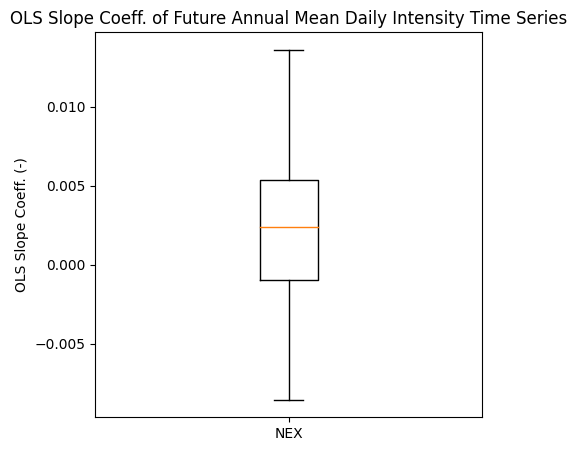

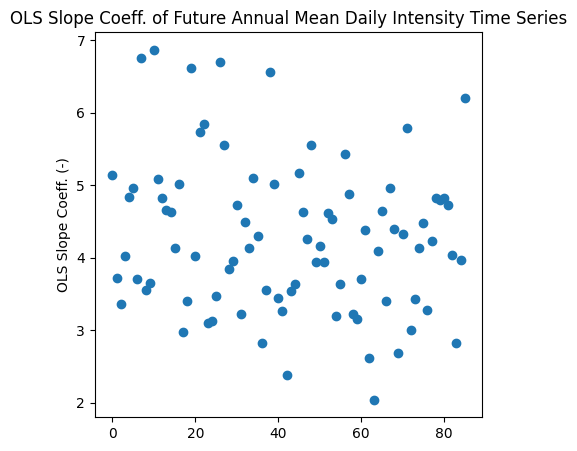

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scipy
import numpy as np
import os

outFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Future_Annual_Mean_MEANP_Trends_Results.csv'
dataFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Future_Annual_Mean_MEANP_Trends_Data.csv'



slopes_df = pd.read_csv(outFILE)
values_df = pd.read_csv(dataFILE)


fig, ax = plt.subplots(figsize=(5, 5))

ax.boxplot([slopes_df['slope']])
ax.set_title('OLS Slope Coeff. of Future Annual Mean Daily Intensity Time Series')
ax.set_ylabel('OLS Slope Coeff. (-)')
ax.set_xticks([1], ['NEX'])
plt.show()



fig, ax = plt.subplots(figsize=(5, 5))

point = '103_328_35_109'
ax.scatter(range(0, len(values_df[point])), values_df[point])
ax.set_title('OLS Slope Coeff. of Future Annual Mean Daily Intensity Time Series')
ax.set_ylabel('OLS Slope Coeff. (-)')
plt.show()






